# Extract geological age from debris flow basins

This notebook represents work in progress.  It aims to extract statistics about the geological age of the rocks underlying the debris flow basins.
The data sources are the digized versions of the Geological maps of the different states:

Location of geological map (CA):

https://mrdata.usgs.gov/geology/state/state.php?state=CA

There is no numerical age in these maps, only the unit name according to the geological time scale.  The data is joined with a tabular representation of the geological time scale to obtain a numerical age range associated with each unit. 

This notebook appends 2 new features(rock age_min,age_max) to <b> "../data/staley16_observations_catchment_fuelpars_rocktype_randn_v3.parquet" </b> and generates new <b> "../data/staley16_observations_catchment_fuelpars_rocktype_randn_rockAge_v4.parquet" </b> file  

In [52]:
import xarray as xr
import rioxarray as rxr 
import rasterio
import pandas as pd

In [55]:
states=['NM', 'CA', 'UT', 'CO', 'MT', 'AZ', 'ID']

Load shapefiles with geological map information. They should already have been retrieved from the [rock type extraction notebook](../data_preparation/extract_rock_type.ipynb) and placed in `../data_preparation/geological_map`.

In [ ]:
## NOTE
## Please run the generate_shape_files.ipynb in data_preparation folder 
## for the .shp files required for this cell
##

import geopandas as gpd

odir="../data_preparation/geological_map"
polys=[gpd.read_file(odir + "/" + state + "_geol_poly.shp") for state in states]
poly=gpd.GeoDataFrame(pd.concat(polys, ignore_index=True), crs='epsg:4326').to_crs('epsg:26911')

In [56]:
len(poly)

70532

In [62]:
sorted(poly["UNIT_LINK"].unique())[0:5]

['AZJTR;0', 'AZJg;0', 'AZJgc;0', 'AZJm;0', 'AZJs;0']

Read CSV files with additional information about the lithology

In [63]:
liths=[gpd.read_file(odir + "/" + state + "_lith.csv") for state in states]
lith=pd.concat(liths, ignore_index=True)

In [64]:
lith.sample(n=1)

,unit_link,lith_rank,lith1,lith2,lith3,lith4,lith5,low_lith,lith_form,lith_com,geometry
4107,IDC;0,Minor,Sedimentary,Clastic,Mudstone,Shale,,Shale,Bed,"Lead Bell Shale, Bloomington Fm, Windy Pass Arg.",None


In [65]:
units=[pd.read_csv(odir + "/" + state + "_units.csv", index_col="unit_link") for state in states]
units=pd.concat(units)

In [66]:
units.sample(n=1).T

unit_link,MTTw;0
state,MT
orig_label,Tw
map_sym1,Tw
map_sym2,Tw;0
prov_no,0
province,NaN
unit_name,Wasatch formation
unit_age,Phanerozoic | Cenozoic | Tertiary
unitdesc,Wasatch formation: Light-colored massive sands...
strat_unit,NaN


Retrieve and save geological timetable from this link: https://figshare.com/articles/dataset/Geological_Event_Chart/8242802

These function read the geological timescale and clean it, e.g. by expanding empty columns downwards, removing special characters, etc.

In [67]:
def clean_age(inage):
    if type(inage) == str:
        return float(inage.replace("~","").split("±")[0])
    elif type(inage) == float:
        return inage
    elif type(inage) == int:
        return float(inage)
    else:
        print(type(inage))
        return np.nan
    
def copy_col_downwards(inl):
    lastval=str(inl[0])
    #assert str(lastval) != 'nan'
    for n in range(1, len(inl)):
        if str(inl[n]) == 'nan':
            inl[n] = lastval
        else:
            lastval = inl[n]
    return inl

def load_and_clean_geol_time():
    gtg=pd.read_excel("../data_preparation/Geological_Event_Chart.xlsx", header=[0,1])["Geological Time"]
    
    #first convert age to float type
    gtg["Age (Ma)"] = gtg["Age (Ma)"].map(clean_age)
    
    #for col in gtg.columns[0:-1]:
    #    gtg[col] = copy_col_downwards(gtg[col])
    
    gtg=gtg.fillna(method='ffill')
    
    for n in range(137,140):
        gtg.loc[n,"Eon"] = 'Pre-Cambrian'    
    
    #re-insert nans in systems that have no series
    #for example, the whole mesozoic is paleocene without this fix
    
    mask=gtg["Era"] == "Mesozoic"
    gtg.loc[mask,"Series/Epoch"] = ''
    
    for system in ['Devonian', 'Silurian','Ordovician','Cambrian']:
        mask=gtg["System"] == system
        gtg.loc[mask,"Series/Epoch"] = ''
        gtg.loc[mask,"Sub-stage"] = ''
        
    for stage in ['Visean', 'Tournasian']:
        mask=gtg["Stage"] == stage
        gtg.loc[mask,"Sub-stage"] = ''
    
    mask=gtg["Eon"] == 'Pre-Cambrian'
    gtg.loc[mask,"Series/Epoch"] = ''
    gtg.loc[mask,"Sub-stage"] = ''

    return gtg

gtg=load_and_clean_geol_time()

This function looks up the age range associated with a geological unit:

In [68]:
import numpy as np

def lookup_geological_age(agestr):
    #gtt=pd.read_excel("geological_timetable/Geological_Event_Chart.xlsx", header=[0,1])
    #gtg=gtt["Geological Time"]
    
    #Tertiary is obsolote; changing accordingly
    if agestr == "Permian Tertiary":
        agestr="Permian"
    
    if len(agestr.split(" ")) > 1:
        fepoch=agestr.split(" ")[0]
        if fepoch.lower() == 'late':
            fepoch = 'Upper'
        elif fepoch.lower() == 'early':
            fepoch = 'Lower'
        unit=agestr.split(" ")[1]
    else:
        fepoch="NA"
        unit=agestr
    
    # force consistent spelling
    if unit == "Precambrian":
        unit="Pre-Cambrian"
    elif unit == "Mississippian":
        unit="Mississipian"
    elif unit == "Permian Tertiary":
        unit = "Permian"
    elif unit == "Paleoproterozoic":
        unit = "Paleo-Proterozoic"
    elif unit == "Mesoproterozoic":
        unit = "Meso-Proterozoic"
    elif unit =="Neoproterozoic":
        unit = "Neo-Proterozoic"
        
    timestrs=gtg.columns.drop("System.1").drop("Age (Ma)")
    
    times={col: list(gtg[col].dropna().unique()) for col in timestrs}
 
    #display(times)
    
    lage=np.nan
    hage=np.nan
    
    for col in times.keys():
        if unit in times[col]:
            #print(col,times[col])
            agerows=gtg[gtg[col] == unit]
            
            if fepoch != "NA" and fepoch in agerows["Series/Epoch.1"].to_list():
                agerows=agerows[agerows["Series/Epoch.1"] == fepoch]

            #display(agerows)

            lage=agerows["Age (Ma)"].values.min()
            hage=agerows["Age (Ma)"].values.max()
    
    # the term tertiary is now obsolete and now in the geolocial time scale
    # putting in the age range manually:
    if unit == 'Tertiary':
        lage=2.6
        hage=66.
        
        
    if np.isnan(lage):
        display(f"no age found for {unit}")
    
    return tuple([lage,hage])
    

In [69]:
lookup_geological_age("Devonian")

(372.2, 419.2)

In [70]:
def clean_geoage(inage):

    if inage.lower().find("late early") >= 0:
        inage=inage.replace("late Early","Early")

        
    if inage.lower().find("early late") >= 0:
        inage=inage.replace("early Late","Late")
 
    return inage

More code to convert inconsistent labeleding to a string that can be found in the table:

In [71]:
#input: geological unit age from geological map
#output: two ages (Ma), representing lower and upper value of age

def process_age(agestr):
    if agestr.find("(") >= 0 and agestr.find("Ma") >= 0:
        numagestr = agestr.split("(")[1].split(")")[0]
        #if numagestr.find("Ma") >= 0:
        age0=float(numagestr.split("-")[0])
        age1=float(numagestr.split("-")[1].split(" ")[0])
        return tuple([age0, age1])
    #else:
    else:
        clnstr=agestr.replace("(?)","").replace("?","").replace(" X","").replace(" Y","").replace(" Z","").replace(" W","")
        clnstr=clnstr.replace(", undivided","").replace(", mixed","").replace(", and",", ")
        
        if clnstr.find(";") >= 0:
            clnstr=clnstr.split(";")[0]
            
        if clnstr.find(" and/or") >= 0:
            sepstr= " and/or "
        elif clnstr.find(" to ") >= 0:
            sepstr=" to "
        elif clnstr.find(" or ") >= 0:
            sepstr=" or "
        elif clnstr.find(" and ") >= 0:
            sepstr=" and "
        elif clnstr.find("|") >= 0:
            sepstr="|"
        elif clnstr.find(", ") >= 0:
            sepstr=","
        elif clnstr.find("-") >= 0:
            sepstr="-"
        else:
            #lower and higher geological age string
            lgage=clnstr
            hgage=clnstr
            hfrac=""
            lfrac=""
            sepstr="NA"
            #print(f"no separation string found for {clnstr}")
            
        if sepstr != "NA":
            lgage=clnstr.split(sepstr)[0].strip()
            hgage=clnstr.split(sepstr)[1].strip()
            
            if lgage.find(" and ") >=0:
                lgage=lgage.split(" and ")[0]
            
            # I don't know how to deal with these, so I'm simplifying:            
            lgage=clean_geoage(lgage)
            hgage=clean_geoage(hgage)

            if len(lgage.split(" ")) == 1 and lgage.lower() in ["early", "middle", "late"]:
                lgage=lgage + " " + hgage.split(" ")[1]
                
        #print(f"{agestr}: {lfrac}, {lgage}; {hfrac}, {hgage}")
        #age0=lookup_geological_age(lfrac + " " + lgage)[0]
        #age1=lookup_geological_age(hfrac + " " + hgage)[1]
        age0=lookup_geological_age(lgage)[0]
        age1=lookup_geological_age(hgage)[1]

        if np.isnan(age0):
            print(f"No age found for (l) '{agestr}', {lgage}")
            
        if np.isnan(age1):
            print(f"No age found for (u) '{agestr}', {hgage}")

        return tuple([age0,age1])

In [72]:
units[units["unit_age"] == 'None']

,state,orig_label,map_sym1,map_sym2,prov_no,province,unit_name,unit_age,unitdesc,strat_unit,unit_com,map_ref,rocktype1,rocktype2,rocktype3,unit_ref,map_symb2
unit_link,,,,,,,,,,,,,,,,,
NMplaya;0,NM,Playa,playa,playa;0,0,NaN,playa,None,NaN,NaN,NaN,NM002,playa,NaN,NaN,NM002,NaN
NMwater;0,NM,Water,water,water;0,0,NaN,water,None,NaN,NaN,NaN,NM002,water,NaN,NaN,NM001,NaN
COwater;0,CO,H2O,water,water;0,0,NaN,water,None,water,NaN,NaN,CO002,water,NaN,NaN,CO001,NaN
MTwater;0,MT,OW,water,water;0,0,NaN,Water,None,NaN,NaN,Unit from original cover not map: unit label O...,MT208,water,NaN,NaN,MT001,NaN


In [73]:
units["num_age"] = units["unit_age"].map(process_age)

'no age found for None'

'no age found for None'

No age found for (l) 'None', None
No age found for (u) 'None', None


'no age found for None'

'no age found for None'

No age found for (l) 'None', None
No age found for (u) 'None', None


'no age found for None'

'no age found for None'

No age found for (l) 'None', None
No age found for (u) 'None', None


'no age found for None'

'no age found for None'

No age found for (l) 'None', None
No age found for (u) 'None', None


The age is a tuple with the upper and lower bound for each unit. The min and max are retrieved and saved in separate columns:

In [74]:
units["age_min"] = units["num_age"].map(lambda x: min(x))
units["age_max"] = units["num_age"].map(lambda x: max(x))
units.drop(columns=["num_age"], inplace=True)

Reading a [previously](../data_preparation/extract_contributing_region.ipynb) generated file with the polygons for each debris flow basin.  These will be joined spatially against the geological map to aggregate rock ages associated with each basin:

In [75]:
# the final file doesnt have these in newarea,geometry and snapdist cols , so cannot use this
# pqfile = "../data/staley16_observations_catchment_fuelpars_rocktype_rxtandn_v3.parquet" 
pqfile= "../data/staley16_sites_catchment_fuelpars_v3.parquet"
stsites=gpd.read_parquet(pqfile).set_crs('epsg:4326').to_crs('epsg:26911')
stsites=stsites[["newarea","geometry","snapdist"]]
print(len(stsites))
stsites.head(n=2)

716


,newarea,geometry,snapdist
SiteID,,,
0,0.335633,"POLYGON ((368683.459 3823257.844, 368692.884 3...",7.152116
1,0.958824,"POLYGON ((367089.469 3824167.720, 367098.894 3...",5.874103


In [76]:
units.sample(n=2)

,state,orig_label,map_sym1,map_sym2,prov_no,province,unit_name,unit_age,unitdesc,strat_unit,unit_com,map_ref,rocktype1,rocktype2,rocktype3,unit_ref,map_symb2,age_min,age_max
unit_link,,,,,,,,,,,,,,,,,,,
COTv;0,CO,Tv,Tv,Tv;0,0,NaN,Volcanic rocks in northwestern Colorado,Phanerozoic | Cenozoic | Tertiary,Mainly of intermediate compositions,NaN,NaN,CO002,intermediate volcanic r,NaN,NaN,CO002,NaN,0.0042,66.0
CAgrMZ1;0,CA,grMz,grMZ1,grMZ1;0,0,NaN,"Mesozoic granitic rocks, unit 1 (Salinian Block)",Early to Late Cretaceous,"Mesozoic granite, quartz monzonite, granodiori...","Bodega Diorite, Santa Lucia Quartz Diorite","Salinian terrane, west-central California. Gra...",CA001,granodiorite,quartz monzonite,tonalite; quartz diorite; granite; alkali-gran...,CA001 CA002 CA018 CA019 CA020 CA022 CA024 CA03...,NaN,100.5000,113.0


In [77]:
mrg=stsites.sjoin(poly, how="left", predicate='intersects').merge(units, left_on="UNIT_LINK", right_index=True)
mrg.head(n=2)

,newarea,geometry,snapdist,index_right,STATE,ORIG_LABEL,SGMC_LABEL,UNIT_LINK,REF_ID,GENERALIZE,...,strat_unit,unit_com,map_ref,rocktype1,rocktype2,rocktype3,unit_ref,map_symb2,age_min,age_max
SiteID,,,,,,,,,,,,,,,,,,,,,
0,0.335633,"POLYGON ((368683.459 3823257.844, 368692.884 3...",7.152116,17002,CA,sch,sch2;0,CAsch2;0,CA294,"Metamorphic, schist",...,"Pelona Schist, Orocopia Schist, Rand Schist, S...","Pelona, Orocopia, and Rand Schists of southern...",CA001,mica schist,mica schist,amphibolite; quartzite; marble; serpentinite,CA001 CA002 CA010 CA015 CA016 CA017 CA022 CA02...,NaN,56.0,72.1
1,0.958824,"POLYGON ((367089.469 3824167.720, 367098.894 3...",5.874103,17002,CA,sch,sch2;0,CAsch2;0,CA294,"Metamorphic, schist",...,"Pelona Schist, Orocopia Schist, Rand Schist, S...","Pelona, Orocopia, and Rand Schists of southern...",CA001,mica schist,mica schist,amphibolite; quartzite; marble; serpentinite,CA001 CA002 CA010 CA015 CA016 CA017 CA022 CA02...,NaN,56.0,72.1


In [78]:
sites_agerange=mrg.groupby("SiteID").agg({"age_min": min, "age_max": max})
sites_agerange=sites_agerange.join(stsites["geometry"].to_crs('epsg:4326'))
sites_agerange=gpd.GeoDataFrame(sites_agerange)
sites_agerange.tail(n=5)

,age_min,age_max,geometry
SiteID,,,
711,15.97,27.82,"POLYGON ((-109.27976 33.67995, -109.27966 33.6..."
712,15.97,27.82,"POLYGON ((-109.26973 33.67408, -109.26962 33.6..."
713,15.97,27.82,"POLYGON ((-109.26211 33.67661, -109.26206 33.6..."
714,15.97,27.82,"POLYGON ((-109.26120 33.65589, -109.26115 33.6..."
715,15.97,27.82,"POLYGON ((-109.27347 33.66086, -109.27337 33.6..."


In [79]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

Histogram of the youngest rock age encountered in the ~700 basins:

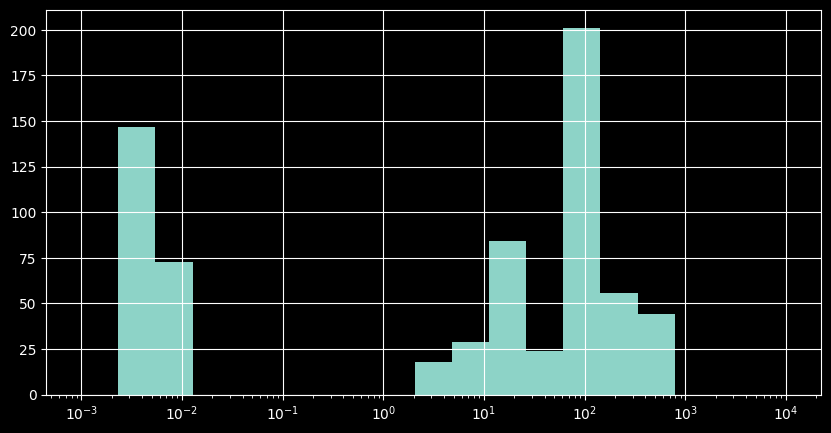

In [80]:
fig,ax=plt.subplots(figsize=(10,5))
ax=sites_agerange["age_min"].hist(bins=np.logspace(-3,4,20))
ax.set_xscale('log')

In [81]:
np.logspace(-3,3,20)

array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03])

Creating a simplified geometry of the basin to make the map render faster:

In [82]:
tol=0.00025
sites_agerange["geometry_simple"]=sites_agerange["geometry"].map(lambda x: x.simplify(tol))
sites_agerange.head(n=2)

,age_min,age_max,geometry,geometry_simple
SiteID,,,,
0,56.0,72.1,"POLYGON ((-118.43109 34.54266, -118.43099 34.5...","POLYGON ((-118.43109 34.54266, -118.42934 34.5..."
1,56.0,72.1,"POLYGON ((-118.44860 34.55066, -118.44849 34.5...","POLYGON ((-118.44860 34.55066, -118.44778 34.5..."


In [83]:
import plotly.express as px
import plotly
plotly.io.templates.default = 'plotly_dark'

Rendering a map view of the debris flow basins, color-coded by numerical age.

In [84]:
sites_agerange["log_min"]=np.log10(sites_agerange["age_min"])
sites_agerange["log_max"]=np.log10(sites_agerange["age_max"])

fig1=px.choropleth_mapbox(sites_agerange, sites_agerange["geometry_simple"],
                     locations=sites_agerange.index,
                     color="log_min",
                     center={"lon": -118.43, "lat": 34.54},
                     height=800,
                     zoom = 8,
                     hover_data=["age_min","age_max"],
                     mapbox_style="stamen-terrain",
                     opacity=0.5)


fig1

Merge again with geological map to obtain geometry of geological unit(s) intersecting catchment:

In [85]:
mrg2=mrg.merge(poly["geometry"], left_on="index_right", right_index=True,
    suffixes=["_c","_g"], how="inner")

Function to compute fraction of overlap between two geometries:

In [86]:
def getpcentoverlap(p1, p2):
    return p1.intersection(p2).area/p1.area

In [87]:
mrg2["Frac"]=mrg2[["geometry_c","geometry_g"]].apply(lambda x: getpcentoverlap(x[0], x[1]), axis=1)

Return minimum and maximum ages of dominant geological unit within catchment:

In [88]:
def min_dom_unit(group):
    idx=group["Frac"].argmax()
    return group["age_min"].iat[idx]

def max_dom_unit(group):
    idx=group["Frac"].argmax()
    return group["age_max"].iat[idx]

def range_dom_unit(group):
    idx=group["Frac"].argmax()
    return group["age_min"].iat[idx], group["age_max"].iat[idx]

Now aggregate to keep properties of dominant geological unit:

In [89]:
sites_dom_age=pd.DataFrame({"age_min": mrg2.groupby("SiteID").apply(min_dom_unit),
                            "age_max": mrg2.groupby("SiteID").apply(max_dom_unit)})

In [90]:
sites_dom_age.sample(n=5)

,age_min,age_max
SiteID,,
93,0.0042,541.00
447,23.0300,635.00
508,66.0000,254.14
338,100.5000,166.10
271,100.5000,166.10


Now load table which contains not just the site properties, but all observations:

In [91]:
stdata=gpd.read_parquet("../data/staley16_observations_catchment_fuelpars_rocktype_randn_v3.parquet")
stdata=stdata.join(sites_dom_age)
stdata.shape

(1550, 46)

In [92]:
type(stdata)

geopandas.geodataframe.GeoDataFrame

Creating a histogram to compare the debris flow occurence of different geological ages:

In [93]:
nodf=stdata[stdata["response"] == 0]
df=stdata[stdata["response"] == 1]

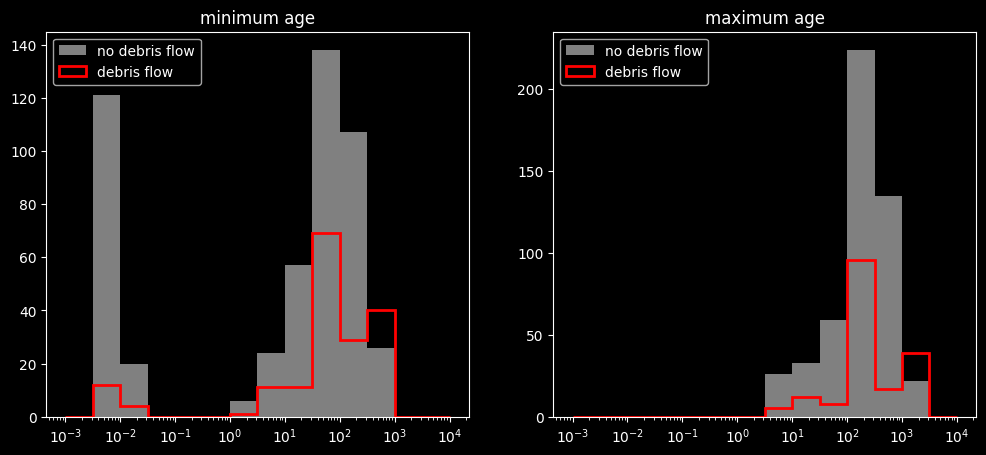

In [95]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
fig,ax=plt.subplots(figsize=(12,5), ncols=2)

bins=np.logspace(-3,4,15)

density=False

label=["minimum age", "maximum age"]

for n, var in enumerate(["age_min", "age_max"]):
    _=ax[n].hist(nodf[var], bins=bins, label="no debris flow", color='gray', density=density)
    _=ax[n].hist(df[var], bins=bins, label="debris flow", histtype="step", 
          color='red', linewidth=2, density=density)
    
    ax[n].legend()
    ax[n].set_xscale('log')
    ax[n].set_title(label[n])

There seems to be a lower frequency of debris flow events in younger geological units (min age < .1 million years) than in older ones.

## Next steps:

1. Scale age to use as a feature (e.g., take log)
2. Deal with missing values
3. Expore the use of metrics other than min/max of dominant unit, e.g., weighted (by coverage area) average of log of age


In [96]:
print(type(stdata),len(stdata))

<class 'geopandas.geodataframe.GeoDataFrame'> 1550


In [97]:
#check how many records have new params missing
stdata['age_max'].isnull().sum()

874

In [98]:
stdata.isnull().sum()

fire_name                        0
year                             0
fire_id                          0
fire_segid                       0
database                         0
state                            0
response                         0
stormdate                        0
gaugedist_m                      0
stormstart                     160
stormend                       160
stormdur_h                       0
stormaccum_mm                    0
stormavgi_mmh                    0
peak_i15_mmh                   230
peak_i30_mmh                   214
peak_i60_mmh                   256
contributingarea_km2             0
prophm23                         0
dnbr1000                        77
kf                               0
acc015_mm                      230
acc030_mm                      214
acc060_mm                      256
geom                             0
lon                              0
lat                              0
SiteID                           0
NB                  

In [99]:
stdata.to_parquet("../data/staley16_observations_catchment_fuelpars_rocktype_randn_rockAge_v4.parquet")